<a href="https://colab.research.google.com/github/aliabbas70/Plant-Disease-Prediction-and-fertilizer-recommendation/blob/main/PlantDiseasePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow matplotlib seaborn opencv-python



In [ ]:
data_dir = '/content/drive/MyDrive/PlantVillage'

In [ ]:
import os, random, shutil
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import json


# PATHS & SETTINGS

src_dir = '/content/drive/MyDrive/PlantVillage'   # original dataset (40k images)
# dest_dir = '/content/drive/MyDrive/PlantVillage_subset'  # smaller subset dataset
IMG_SIZE = 128
BATCH_SIZE = 32
per_class_limit = 1000  # max images per class (adjust as needed)
random.seed(42)


# CREATE SUBSET DATASET

#  if not os.path.exists(dest_dir):
#      os.makedirs(dest_dir)

# classes = [d for d in os.listdir(src_dir) if os.path.isdir(os.path.join(src_dir, d))]
# print(f"Found {len(classes)} classes")

# for cls in classes:
#     src_cls_dir = os.path.join(src_dir, cls)
#     dest_cls_dir = os.path.join(dest_dir, cls)
#     if not os.path.exists(dest_cls_dir):
#         os.makedirs(dest_cls_dir)

#     files = [f for f in os.listdir(src_cls_dir) if os.path.isfile(os.path.join(src_cls_dir, f))]
#     random.shuffle(files)

#     take = min(per_class_limit, len(files))
#     chosen = files[:take]

#     for fname in chosen:
#         src_path = os.path.join(src_cls_dir, fname)
#         dst_path = os.path.join(dest_cls_dir, fname)
#         # Check if the source file exists before copying
#         if os.path.exists(src_path):
#             shutil.copy2(src_path, dst_path)
#         else:
#             print(f"Warning: Source file not found, skipping: {src_path}")


#     print(f"Class: {cls} -> copied {len(chosen)} / {len(files)}")

# print("✅ Subset creation complete. Using:", dest_dir)


# DATA GENERATORS

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2,
    shear_range=0.2,
   brightness_range=[0.7, 1.3],
   width_shift_range=0.1,
   height_shift_range=0.1

)


train_generator = datagen.flow_from_directory(
    src_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)
with open("/content/drive/MyDrive/class_indices4.json", "w") as f:
    json.dump(train_generator.class_indices, f)

validation_generator = datagen.flow_from_directory(
    src_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Detect number of classes automatically
num_classes = len(train_generator.class_indices)
print("Number of classes:", num_classes)


# MODEL SETUP (MobileNetV2)

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = True # Freeze base layers #BUT NOW TRUE FOR FINE TUNING

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
# Recompile the model after setting the base model to trainable
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
import json
# with open("class_indices4.json", "w") as f:
#     json.dump(train_generator.class_indices, f)



# TRAINING

# early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# history = model.fit(
#     train_generator,
#     validation_data=validation_generator,
#     epochs=10,
#     callbacks=[early_stop]
# )

Found 16516 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.
Number of classes: 15


In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[early_stop]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 3982s 8s/step - accuracy: 0.1651 - loss: 2.8527 - val_accuracy: 0.2707 - val_loss: 2.3536
Epoch 2/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 1325s 3s/step - accuracy: 0.5131 - loss: 1.5849 - val_accuracy: 0.4408 - val_loss: 1.7793
Epoch 3/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 1335s 3s/step - accuracy: 0.6783 - loss: 1.0707 - val_accuracy: 0.5895 - val_loss: 1.2699
Epoch 4/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 1406s 3s/step - accuracy: 0.7502 - loss: 0.7998 - val_accuracy: 0.6951 - val_loss: 0.9491
Epoch 5/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 1314s 3s/step - accuracy: 0.8010 - loss: 0.6297 - val_accuracy: 0.7800 - val_loss: 0.6874
Epoch 6/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 1342s 3s/step - accuracy: 0.8403 - loss: 0.5211 - val_accuracy: 0.8423 - val_loss: 0.4900
Epoch 7/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 1390s 3s/step - accuracy: 0.8558 - loss: 0.4627 - val_accuracy: 0.8872 - val_loss: 0.3529
Epoch 8/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 1322s 3s/step - accuracy: 0.8814 - loss: 0.3864 - 

### Next Steps: Evaluate and Use the Model

Now that the model has been trained, you can evaluate its performance on the validation set and use it to make predictions on new images.

#### Evaluate the Model

Use the `evaluate` method to get the loss and accuracy on the validation data.

In [ ]:
loss, accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

129/129 ━━━━━━━━━━━━━━━━━━━━ 84s 648ms/step - accuracy: 0.9369 - loss: 0.1890
Validation Loss: 0.1761
Validation Accuracy: 0.9435


#### Make Predictions on New Images

You can load a new image and use the `predict` method to get the class probabilities. Then, use the `class_indices` to get the predicted class label.

In [ ]:
# Example of how to load and preprocess a single image for prediction
from tensorflow.keras.preprocessing import image
import numpy as np

img_path = '/content/drive/MyDrive/PlantVillage/Tomato_Leaf_Mold/08cdd6ec-9dd7-4fc2-a255-11a70adaffd4___Crnl_L.Mold 9177.JPG' # Replace with the path to your image
img = image.load_img(img_path, target_size=(128, 128))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions)

# Load the class indices if you haven't already
with open("/content/drive/MyDrive/class_indices4.json", "r") as f:
    class_indices4 = json.load(f)

# Invert the dictionary to get class names from indices
idx_to_class = {v: k for k, v in class_indices4.items()}

predicted_class_label = idx_to_class[predicted_class_index]
confidence = predictions[0][predicted_class_index]

print(f"Predicted class: {predicted_class_label}")
print(f"Confidence: {confidence:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted class: Tomato_Leaf_Mold
Confidence: 0.8730


#### Visualize Predictions

You can display the image and the prediction result.

In [ ]:
import matplotlib.pyplot as plt

# Display the image
img_display = image.load_img(img_path)
plt.imshow(img_display)
plt.title(f"Predicted: {predicted_class_label} (Confidence: {confidence:.2f})")
plt.axis('off')
plt.show()

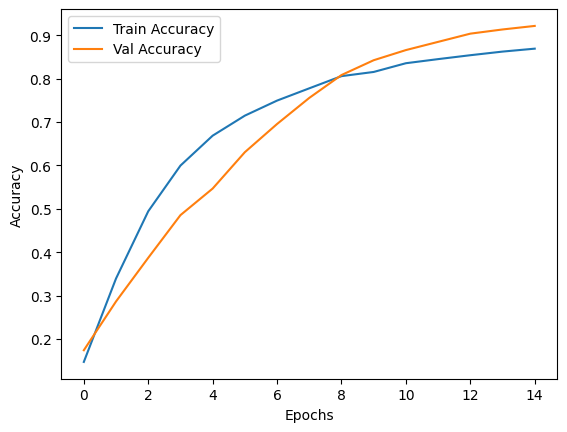

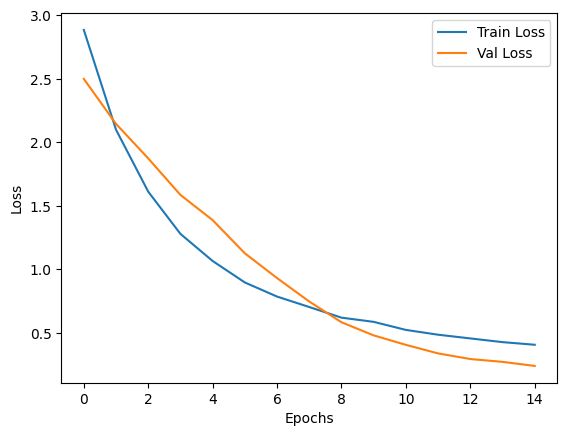

In [ ]:
import matplotlib.pyplot as plt

# Training curves plot karo
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


85/85 ━━━━━━━━━━━━━━━━━━━━ 24s 227ms/step


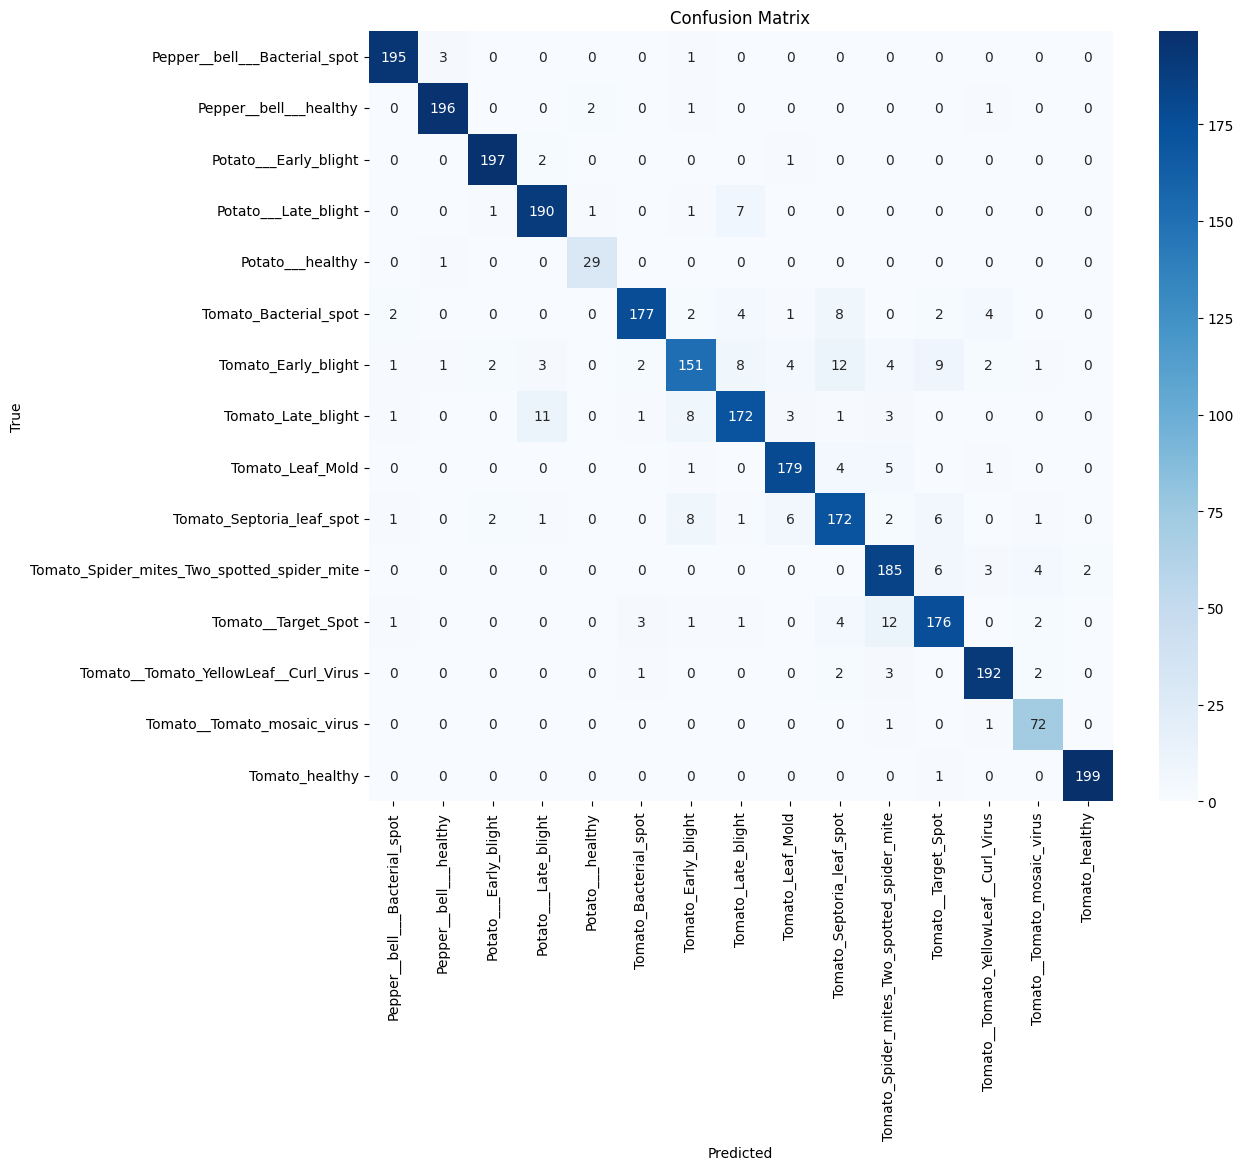

                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.97      0.98      0.97       199
                     Pepper__bell___healthy       0.98      0.98      0.98       200
                      Potato___Early_blight       0.98      0.98      0.98       200
                       Potato___Late_blight       0.92      0.95      0.93       200
                           Potato___healthy       0.91      0.97      0.94        30
                      Tomato_Bacterial_spot       0.96      0.89      0.92       200
                        Tomato_Early_blight       0.87      0.76      0.81       200
                         Tomato_Late_blight       0.89      0.86      0.88       200
                           Tomato_Leaf_Mold       0.92      0.94      0.93       190
                  Tomato_Septoria_leaf_spot       0.85      0.86      0.85       200
Tomato_Spider_mites_Two_spotted_spider_mite       0.86      0.93

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = validation_generator.classes

# Correct class labels
class_labels = list(validation_generator.class_indices.keys())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes, labels=range(len(class_labels)))

plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Classification report
print(classification_report(y_true, y_pred_classes, target_names=class_labels, labels=np.unique(y_true)))

In [ ]:
model.save('/content/drive/MyDrive/plant_disease_model4.keras')


In [ ]:
import cv2
import numpy as np
import tensorflow as tf

# Load trained model once
MODEL_PATH = '/content/drive/MyDrive/plant_disease_model2.keras'
model = tf.keras.models.load_model(MODEL_PATH)

with open("class_indices.json", "r") as f:
    class_indices = json.load(f)


# Invert dictionary to map index -> class name
idx_to_class = {v: k for k, v in class_indices.items()}
image_path='/content/drive/MyDrive/PlantVillage_subset/Tomato_healthy/000146ff-92a4-4db6-90ad-8fce2ae4fddd___GH_HL Leaf 259.1.JPG'
def predict_leaf(image_path, model, img_size=128):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Image not loaded from {image_path}")
        return None, None

    # Preprocess image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img_size, img_size))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    # Prediction
    preds = model.predict(img)
    class_idx = np.argmax(preds)
    class_label = idx_to_class[class_idx]
    confidence = preds[0][class_idx]

    print(f"Predicted Class: {class_label} | Confidence: {confidence:.2f}")
    return class_label, confidence


# Example test
image_path = '/content/drive/MyDrive/PlantVillage_subset/Tomato_healthy/000146ff-92a4-4db6-90ad-8fce2ae4fddd___GH_HL Leaf 259.1.JPG'
predict_leaf(image_path, model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted Class: Tomato_healthy | Confidence: 0.88


('Tomato_healthy', np.float32(0.8790619))